<a href="https://colab.research.google.com/github/rajatc2/Machine-Learning/blob/main/PDF-Estimation/PDF_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PDF Estimation

# 0. Prepare Data

In [2]:
!apt install libomp-dev
!pip install faiss-cpu

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libomp-14-dev libomp5-14
Suggested packages:
  libomp-14-doc
The following NEW packages will be installed:
  libomp-14-dev libomp-dev libomp5-14
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 738 kB of archives.
After this operation, 8,991 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp5-14 amd64 1:14.0.0-1ubuntu1.1 [389 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp-14-dev amd64 1:14.0.0-1ubuntu1.1 [347 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libomp-dev amd64 1:14.0-55~exp2 [3,074 B]
Fetched 738 kB in 1s (1,067 kB/s)
Selecting previously unselected package libomp5-14:amd64.
(Reading database ... 123605 files and directories currently installed.)
Preparing to unpack .../libomp5-14_1%3a

In [3]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/hw4/" # revise as needed
im = cv2.imread(datadir + '3985783648_4702b45d13_c.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread(datadir + '3985783648_4702b45d13_c_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255

Mounted at /content/drive


In [4]:
print(im.shape)
print(crop.shape)

h=im.shape[0]
w=im.shape[1]
colr=im.shape[2]

print(h,w,colr)

(532, 799, 3)
(133, 203, 3)
532 799 3


In [5]:
def display_score_maps(im, score_map, thresh):
  '''
    Input: im (h, w, 3): RGB image
           score_map (h, w, 1) or (h*w, 1)
           thresh: floating point threshold, typically between -2 and 2
  '''
  plt.imshow(im)
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map, (im.shape[:2])))
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  plt.imshow(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)
  plt.axis('off')
  plt.show()

# 1. Per-Dimension Discrete Pdf

In [6]:
# estimate discrete pdf
def estimate_discrete_pdf(x, K, prior=1):
  '''
    Input: x(nx, ): an array of discrete values from 0 to K-1
           K: number of possible discrete values
           prior: initial count for each discrete value
    Output: p(nvalues, ): p[i] is the estimated probability of discrete value i

    This function can be used for Method 1 and Method 2
  '''

  p = np.ones(K,)*prior # initialize p
  # TO DO:
  # (1) loop through values
  # (2) increment element of p corresponding to each value
  # (3) divide by sum of p
  for v in x:
    p[v] += 1
  ptotal = p.sum()
  #print(p)
  #print(ptotal)
  for v in range(len(p)):
    p[v] = p[v] /ptotal
  return p

(425068, 1)


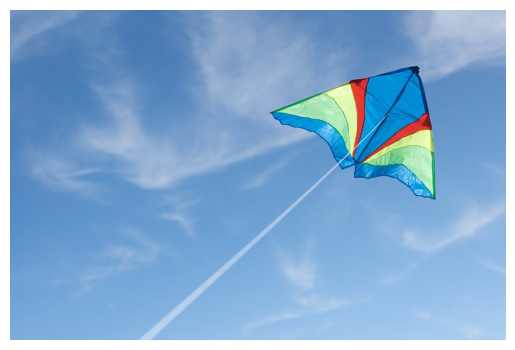

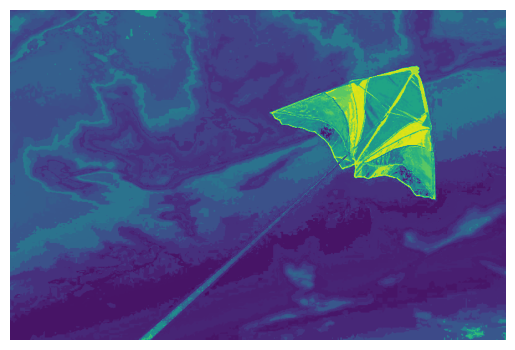

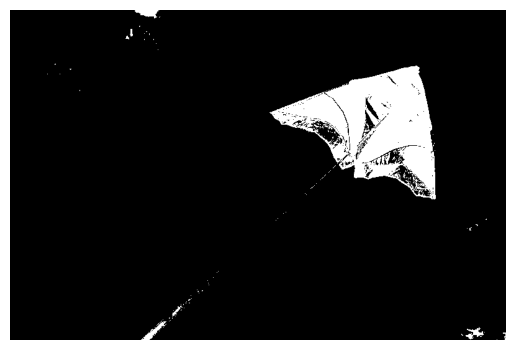

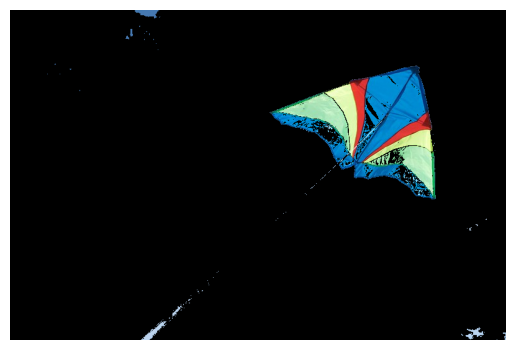

In [7]:
# set number of bins K
K=32

# reshape pixels to (h*w, 3)
im_reshaped = im.reshape(-1, 3)
crop_reshaped=crop.reshape(-1, 3)
#print('Reshaped shape:', im_reshaped.shape)
#print(im_reshaped.max(),im_reshaped.min())

# convert continuous values to discrete values ranging from 0 to K-1
# e.g. x-->min(int(x*K), K-1) if x ranges from 0 to 1
#x=min(int(im_reshaped*K), K-1)
im_discrete = np.digitize(im_reshaped, np.arange(K)/K) - 1
crop_discrete = np.digitize(crop_reshaped, np.arange(K)/K) - 1
#print('Shape of discrete array:', im_discrete.shape)
#print('Range of discrete values:', np.min(im_discrete), np.max(im_discrete))

# get pdf for each dimension using estimate_discrete_pdf
im_pdf_r=estimate_discrete_pdf(im_discrete[:, 0], K, prior=0)
im_pdf_g=estimate_discrete_pdf(im_discrete[:, 1], K, prior=0)
im_pdf_b=estimate_discrete_pdf(im_discrete[:, 2], K, prior=0)

crop_pdf_r=estimate_discrete_pdf(crop_discrete[:, 0], K, prior=0)
crop_pdf_g=estimate_discrete_pdf(crop_discrete[:, 1], K, prior=0)
crop_pdf_b=estimate_discrete_pdf(crop_discrete[:, 2], K, prior=0)

# estimate score for each pixel in full image according to log pdfs
score_map=np.zeros((h*w,1))

for i in range(h*w):
    score_map[i]=np.log(crop_pdf_r[im_discrete[i,  0]]*crop_pdf_g[im_discrete[i, 1]]*crop_pdf_b[im_discrete[i, 2]])\
    -np.log(im_pdf_r[im_discrete[i, 0]]*im_pdf_g[im_discrete[i, 1]]*im_pdf_b[im_discrete[i, 2]])

print(score_map.shape)

# display
display_score_maps(im, score_map, 1)

In [8]:
pdf_r, _ = np.histogram(im_discrete[:, 0], bins=K)
pdf_g, _ = np.histogram(im_discrete[:, 1], bins=K)
pdf_b, _ = np.histogram(im_discrete[:, 2], bins=K)
#pdf_g, _ = np.histogram(im_reshaped[:, 1], bins=K, range=(0, K))
#pdf_b, _ = np.histogram(im_reshaped[:, 2], bins=K, range=(0, K))
print(np.sum(pdf_r))
print(np.sum(pdf_g))
print(np.sum(pdf_b))

print(pdf_r)
print(pdf_g)
print(pdf_b)

# Normalize the per-channel probabilities
pdf_r = pdf_r/np.sum(pdf_r)
pdf_g =pdf_g/ np.sum(pdf_g)
pdf_b =pdf_b/ np.sum(pdf_b)

425068
425068
425068
[11748  1538   790   500   360   370   378   367   863 16191 19325 27253
 40945 40442 43369 49981 39248 33236 32729 26100 15248  8766  5897  3064
   854   556   668  1679  1529   734   274    66]
[   10    51   156   233   270   360  1017  1389   560   361   342   338
   508   531   735 15315 28802 33099 42567 53006 60749 60068 42603 30897
 28502 11625  1693   937  2157  2120  1865  2202]
[   32    60   127   183   213   544  1068   608   371   273   280   261
   314   325   372   518   632   794   824   788  1031  1729 23129 44627
 44325 82223 76588 62122 48242 30963  1067   435]


# 2. K-Means

(425068, 1)


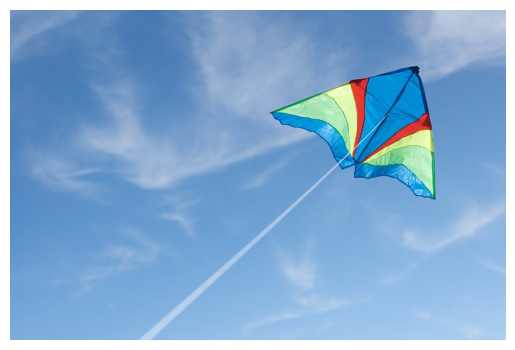

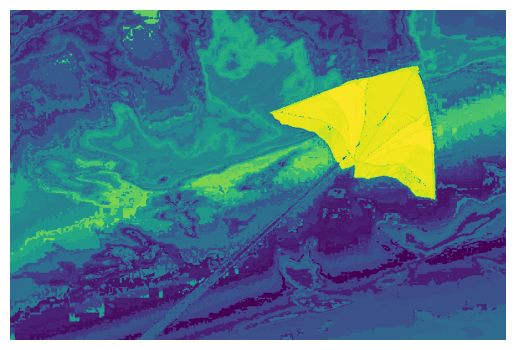

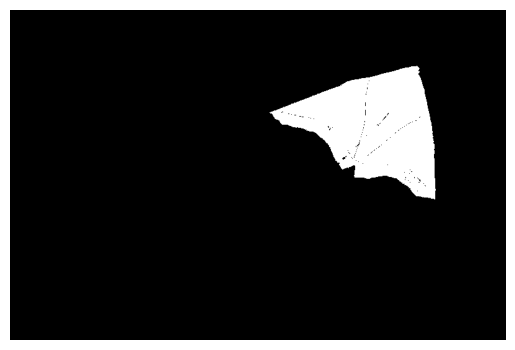

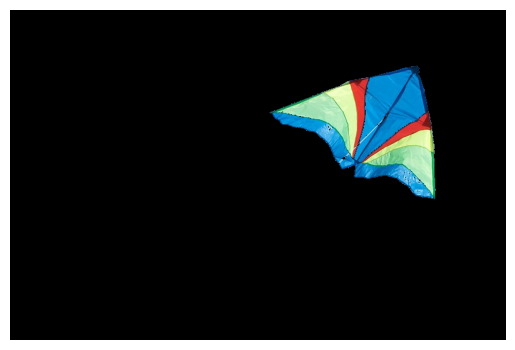

In [12]:
import faiss

im = cv2.imread(datadir + '3985783648_4702b45d13_c.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread(datadir + '3985783648_4702b45d13_c_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255

# set K
K=128

# reshape pixels to (h*w, 3)
im_reshaped = im.reshape(-1, 3)
crop_reshaped=crop.reshape(-1, 3)
dim=im_reshaped.shape[1]

# discretize all three color channels together using KMeans
kmeans = faiss.Kmeans(dim, K, niter=50,nredo=5, verbose=True)
kmeans.train(im_reshaped)

dist1, im_idx = kmeans.index.search(im_reshaped, 1)
dist2, crop_idx = kmeans.index.search(crop_reshaped, 1)
# get pdf over discrete values
im_pdf=estimate_discrete_pdf(im_idx, K, prior=1)
crop_pdf=estimate_discrete_pdf(crop_idx, K, prior=1)

# estimate score for each pixel in full image according to log pdfs
score_map=np.zeros((h*w,1))

for i in range(h*w):
    score_map[i]=np.log(crop_pdf[im_idx[i]])-np.log(im_pdf[im_idx[i]])

print(score_map.shape)

# display
display_score_maps(im, score_map, 1)

# 3. Gaussian Mixture Model (GMM)

(425068,)


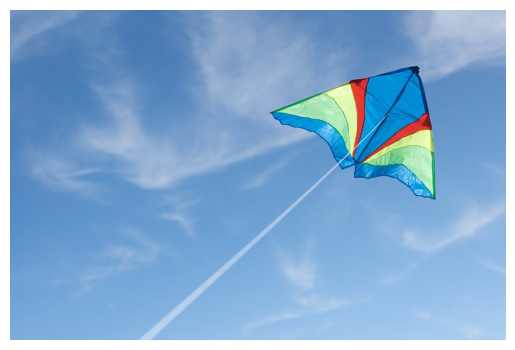

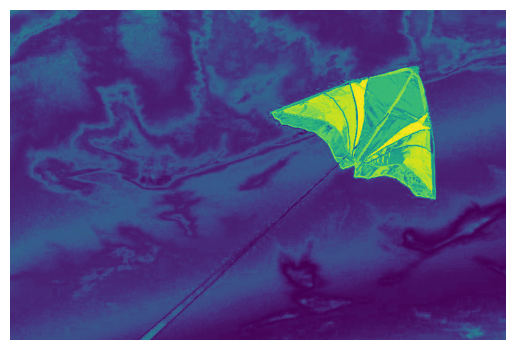

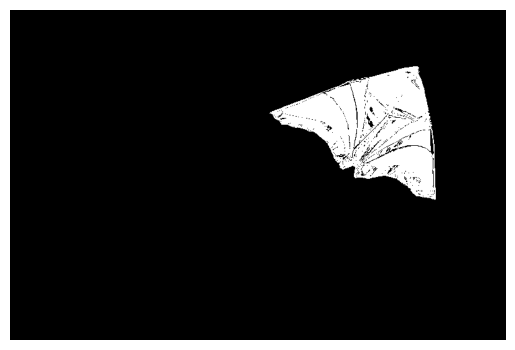

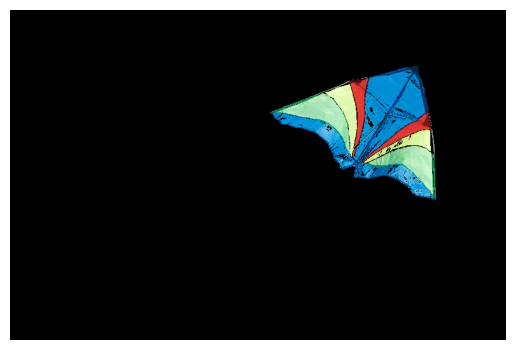

In [11]:
from sklearn.mixture import GaussianMixture


im = cv2.imread(datadir + '3985783648_4702b45d13_c.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread(datadir + '3985783648_4702b45d13_c_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255

# set K
K=5

# reshape pixels to (h*w, 3)
im_reshaped = im.reshape(-1, 3)
crop_reshaped=crop.reshape(-1, 3)
dim=im_reshaped.shape[1]

# get joint pdf using GMMs (choose number of components and other parameters)
im_gmm=GaussianMixture(n_components=K, n_init=3, tol=np.std(im_reshaped)/50,covariance_type='diag', max_iter=100)
im_gmm.fit(im_reshaped)

crop_gmm=GaussianMixture(n_components=K, n_init=3, tol=np.std(im_reshaped)/50,covariance_type='diag', max_iter=100)
crop_gmm.fit(crop_reshaped)

im_gmm_score= im_gmm.score_samples(im_reshaped)
crop_gmm_score= crop_gmm.score_samples(im_reshaped)


# estimate score for each pixel in full image according to log pdfs
score_map=crop_gmm_score - im_gmm_score
print(score_map.shape)

# display
display_score_maps(im, score_map, 1)

# 4. Segmentation (using discrete PDF) after Applying PCA

<ipython-input-14-917484c0ac1e>:44: RuntimeWarning: divide by zero encountered in log
  score_map[i]=np.log(crop_pdf_r[im_discrete[i,  0]]*crop_pdf_g[im_discrete[i, 1]]*crop_pdf_b[im_discrete[i, 2]])\


(425068, 1)


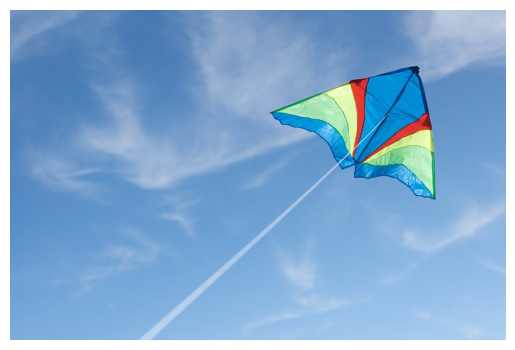

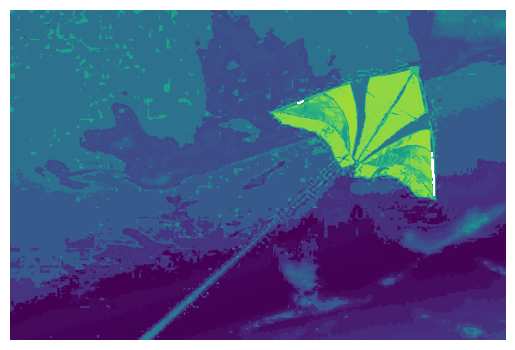

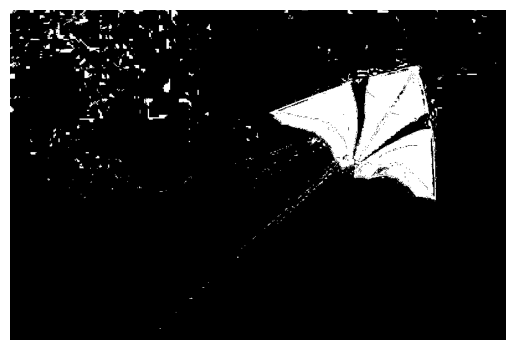

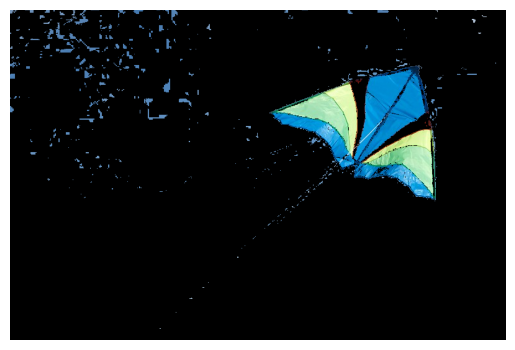

In [14]:
from sklearn.decomposition import PCA

# set number of bins K
K=32

im = cv2.imread(datadir + '3985783648_4702b45d13_c.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread(datadir + '3985783648_4702b45d13_c_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255

# reshape pixels to (h*w, 3)
im_reshaped = im.reshape(-1, 3)
crop_reshaped=crop.reshape(-1, 3)

pca = PCA()

# Fit the PCA model to the data
pca.fit(im_reshaped)

# Transform the data to the new coordinate system
im_transformed = pca.transform(im_reshaped)
crop_transformed=pca.transform(crop_reshaped)


# convert continuous values to discrete values ranging from 0 to K-1
# e.g. x-->min(int(x*K), K-1) if x ranges from 0 to 1
#x=min(int(im_reshaped*K), K-1)
im_discrete = np.digitize(im_transformed, np.arange(K)/K) - 1
crop_discrete = np.digitize(crop_transformed, np.arange(K)/K) - 1

# get pdf for each dimension using estimate_discrete_pdf
im_pdf_r=estimate_discrete_pdf(im_discrete[:, 0], K, prior=0)
im_pdf_g=estimate_discrete_pdf(im_discrete[:, 1], K, prior=0)
im_pdf_b=estimate_discrete_pdf(im_discrete[:, 2], K, prior=0)

crop_pdf_r=estimate_discrete_pdf(crop_discrete[:, 0], K, prior=0)
crop_pdf_g=estimate_discrete_pdf(crop_discrete[:, 1], K, prior=0)
crop_pdf_b=estimate_discrete_pdf(crop_discrete[:, 2], K, prior=0)

# estimate score for each pixel in full image according to log pdfs
score_map=np.zeros((h*w,1))

for i in range(h*w):
    score_map[i]=np.log(crop_pdf_r[im_discrete[i,  0]]*crop_pdf_g[im_discrete[i, 1]]*crop_pdf_b[im_discrete[i, 2]])\
    -np.log(im_pdf_r[im_discrete[i, 0]]*im_pdf_g[im_discrete[i, 1]]*im_pdf_b[im_discrete[i, 2]])

print(score_map.shape)

# display
display_score_maps(im, score_map, 1)